In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import sys

In [ ]:
torch.cuda.empty_cache()

In [ ]:
training_data_hazy = []
training_data_gt = []

In [ ]:
ground_truth_path = '/home/c3ilab/Downloads/Dataset/gt'
hazy_images_path = '/home/c3ilab/Downloads/Dataset/hazy'

In [ ]:
IMG_SIZE = 256

EPOCHS = 1000
batch_size = 1
learning_rate = 0.001

In [ ]:
for file in range(1, 1000):
  f = "{:d}".format(file) + '.png'
  path=os.path.join(ground_truth_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  training_data_gt.append(np.array(img))

In [ ]:
for file in range(1, 1000):
  f = "{:d}".format(file) + '.png'
  path = os.path.join(hazy_images_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  img_mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = np.dstack((img, img_mask))
  training_data_hazy.append(np.array(img))

In [ ]:
X_orig=torch.Tensor([training_data_gt[i] for i in range(len(training_data_gt))])
X_hazy=torch.Tensor([training_data_hazy[i] for i in range(len(training_data_hazy))])

X_orig=X_orig/255
X_hazy_seg=X_hazy/255

/tmp/ipykernel_36482/4217046044.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343970094/work/torch/csrc/utils/tensor_new.cpp:245.)
  X_orig=torch.Tensor([training_data_gt[i] for i in range(len(training_data_gt))])


In [ ]:
X_orig_flat=np.transpose(X_orig,(0,3,1,2))
X_hazy_flat=np.transpose(X_hazy,(0,3,1,2))

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(4,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

encoder = Encoder().cuda()

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,2,1,1),
                        nn.ReLU()
        )

    def forward(self,x):
        out = x.view(batch_size,256,64,64)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

In [ ]:
parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
losses=[]
X_orig1=X_orig

for epoch in tqdm(range(EPOCHS)):

    rand_idx=torch.randperm(X_orig1.size()[0])
    X_orig_iter=X_orig[rand_idx]
    X_hazy_iter=X_hazy[rand_idx]

    X_orig_iter1=np.transpose(X_orig_iter,(0,3,1,2))
    X_hazy_iter1=np.transpose(X_hazy_iter,(0,3,1,2))

    train_orig_loader = torch.utils.data.DataLoader(dataset=X_orig_iter1,batch_size=batch_size,shuffle=False)
    train_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_iter1,batch_size=batch_size,shuffle=False)

    for train_orig, train_hazy in zip(train_orig_loader, train_hazy_loader):
        orig_image = Variable(train_orig).cuda()
        hazy_image = Variable(train_hazy).cuda()

        optimizer.zero_grad()

        encoder_op = encoder(hazy_image)
        output = decoder(encoder_op)

        loss=loss_func(output,orig_image)
        loss.backward()
        optimizer.step()
    losses.append(loss)

loss_list = [loss.cpu().detach().numpy() for loss in losses]

100%|█████████████████████████████████████| 1000/1000 [3:40:58<00:00, 13.26s/it]


In [ ]:
torch.save([encoder,decoder],'dehaze_autoencoder_gray.pkl')

In [ ]:
with open(r'loss_with_GrayMask', 'w') as fp:
    for item in loss_list:
        fp.write("%s\n" % item)
    print('Done')

Done


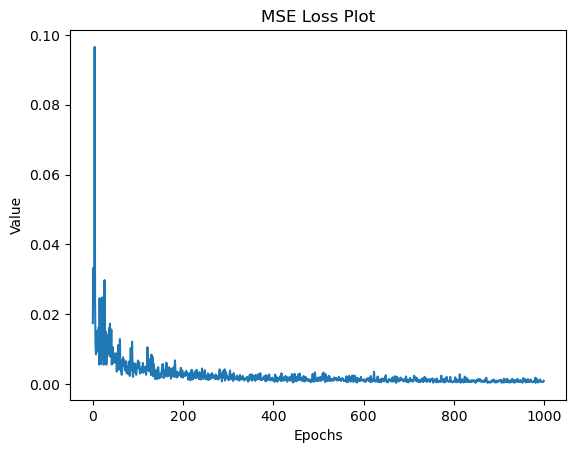

In [ ]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(loss_list)
plt.show()